In [20]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os

TypeError: get_duration() takes 0 positional arguments but 1 was given

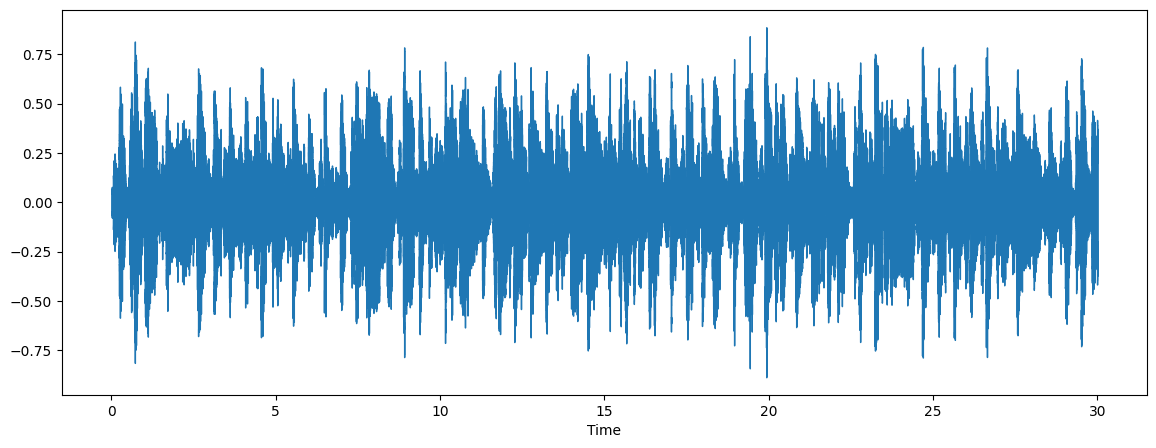

<Figure size 1400x500 with 0 Axes>

In [31]:
def create_spectogram(file_path, display_plots, save_path):
    x, sr = librosa.load(file_path, sr=44100)
    if display_plots:
        plt.figure(figsize=(14, 5))
        librosa.display.waveshow(x, sr=sr)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    figure = plt.figure(figsize=(14, 5))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path))
    plt.axis('off')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.axis('on')
    if not display_plots:
        plt.close(figure)


audio_files_root_dir = 'Data/genres_original/'
display_plots = True

for subdir, dirs, files in os.walk(audio_files_root_dir):
    for file in files:
        file_info = file.split('.')
        create_spectogram(os.path.join(subdir, file), display_plots, f'Data/spectograms/{file_info[0]}/{file_info[0]}.{file_info[1]}.png')
        display_plots = False